In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import math
import numpy as np
import scipy.io
from scipy.interpolate import interp1d

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GaussianSymmetrizedKLKernel, MaternKernel

from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf

from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior

In [6]:
def loadmatlab(filename):
    mat = scipy.io.loadmat(filename, appendmat=True)
    mat_contents = mat[filename]
    N = len(mat_contents)
    P = np.zeros(N)
    corr_length = np.zeros(N)
    dens_fluc = np.zeros(N)

    for i in range(N):
        P[-1-i] = mat_contents[i][0]
        corr_length[-1-i] = mat_contents[i][1]
        dens_fluc[-1-i] = mat_contents[i][2]

    return P, corr_length, dens_fluc

In [7]:
dtype = torch.float


# Loading the data
P, corr_length, dens_fluc = loadmatlab('B1')

# Creating a cubic interpolation based on the gathered data
def f(x):
    f_interp = interp1d(P, corr_length, kind='cubic')

    return f_interp(x)

# For plotting purposes only
plot_x = np.linspace(P.min(), P.max(), 1001)
plot_y = f(plot_x)
actual_max = plot_x[np.where(plot_y == plot_y.max())[0]]

# Normalized pressure values
norm_P = (P - P.min())/(P.max() - P.min())

bounds = torch.stack([torch.zeros(1), torch.ones(1)])

# Pick which samples to start with
train_X = [[norm_P[0]], [norm_P[len(P)//4]], [norm_P[len(P)//2]], [norm_P[-1]]]
train_Y = [[corr_length[0]], [corr_length[len(P)//4]], [corr_length[len(P)//2]], [corr_length[-1]]]
train_X = torch.tensor(train_X)
train_Y = torch.tensor(train_Y)

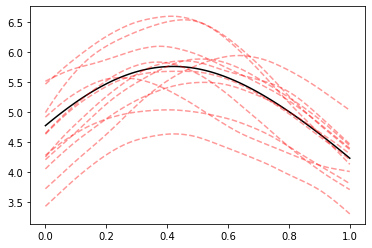

In [15]:
#lscale = SmoothedBoxPrior(0, 0.1)
covar_module = RBFKernel()
gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

x = torch.linspace(0, 1, 100).unsqueeze(1).double()
posterior = gp.posterior(x)

draws = posterior.sample(sample_shape=torch.Size([12]))

plt.plot(x, posterior.mean.detach(), color='black')
for k in range(12): plt.plot(x, draws[k].detach(), c='red', alpha=0.4, linestyle='dashed')